# Implement a convolution estimator for the MNIST problem


In [1]:
import os
import sys
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import tensorflow as tf
import argparse

#from skimage.io import imread, imsave, imshow
from sklearn.model_selection import train_test_split

np.random.seed(111)


os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = '0'

print(tf.__version__)

/Users/jorge/anaconda3/envs/tm/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


1.7.0


# Load data

In [2]:
(X_trn, y_trn), (X_tst, y_tst) = tf.keras.datasets.mnist.load_data(path='/tmp/mnist.npz')

#X_trn = np.array(X_trn/255.0, dtype=np.float32)
#y_trn = np.array(y_trn, dtype=np.int32)


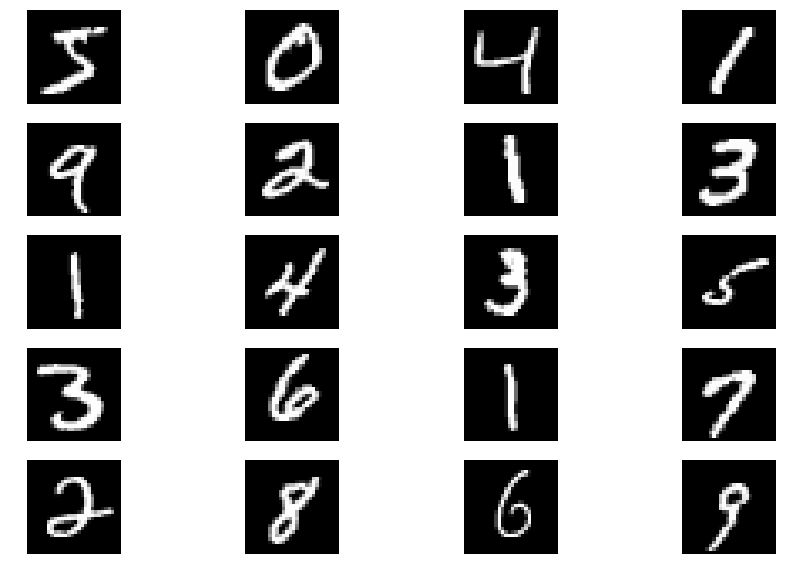

In [3]:
# Plot some images
%matplotlib inline

f, ax = plt.subplots(5,4, figsize=(15,10))

for i, img in enumerate(X_trn[:20]):
    ax[i//4, i%4].imshow(img, cmap='gray')
    ax[i//4, i%4].axis('off')
plt.show()  

# Create the input_functions

In [4]:
# Define the train and eval datasets
# From https://github.com/tensorflow/models/blob/master/samples/core/get_started/iris_data.py

def decode_image(image):
    # Normalize from [0, 255] to [0.0, 1.0]
    image = tf.cast(image, tf.float32)
    return image / 255.0

def decode_label(label):
    label = tf.cast(label, tf.int32)
    return label


def train_input_fn(features, labels, batch_size):
    """An input function for training"""
    inputs = features

    # Convert the inputs to a Dataset.
    ds_images = tf.data.Dataset.from_tensor_slices(inputs).map(decode_image)
    ds_labels = tf.data.Dataset.from_tensor_slices(labels).map(decode_label)
    dataset = tf.data.Dataset.zip((ds_images, ds_labels))
    
    # Shuffle, repeat, and batch the examples.
    dataset = dataset.cache().shuffle(buffer_size=1000).repeat().batch(batch_size)

    # GEnerate iterator and return the next elements of the iterator
    # in 1.6 yand above ou can pass directly the dataset and the estimator build internaly the iterator.
    (images, labels) = dataset.make_one_shot_iterator().get_next()
    return (images, labels)


def eval_input_fn(features, labels, batch_size):
    """An input function for evaluation or prediction"""
    
    inputs = features
    ds_images = tf.data.Dataset.from_tensor_slices(inputs).map(decode_image)

    if labels is None:
        dataset = ds_images
    else:
        ds_labels = tf.data.Dataset.from_tensor_slices(labels).map(decode_label)
        dataset = tf.data.Dataset.zip((ds_images, ds_labels))

    # Batch the examples
    dataset = dataset.batch(batch_size)

    (images, labels) = dataset.make_one_shot_iterator().get_next()
    
    return (images, labels)





In [5]:
# Configure the model architecture

class Model(tf.keras.models.Model):
    """Model to recognize digits in the MNIST dataset.
    """

    def __init__(self):
        super(Model, self).__init__()
        
        # Define layers to use in the model
        self._input_shape = [-1, 28, 28, 1]

        self.conv1 = tf.layers.Conv2D(32, 5, padding='same', activation=tf.nn.relu)
        self.max_pool2d = tf.layers.MaxPooling2D((2, 2), (2, 2), padding='same')
    
        self.conv2 = tf.layers.Conv2D(64, 5, padding='same', activation=tf.nn.relu)
    
        self.fc1 = tf.layers.Dense(1024, activation=tf.nn.relu)
        self.dropout = tf.layers.Dropout(0.4)
    
        self.fc2 = tf.layers.Dense(10)

    
    def __call__(self, inputs, training):
        """Add operations to classify a batch of input images.
        Args:
          inputs: A Tensor representing a batch of input images.
          training: A boolean. Set to True to add operations required only when
            training the classifier.
        Returns:
          A logits Tensor with shape [<batch_size>, 10].
        """
        y = tf.reshape(inputs, self._input_shape)
        y = self.conv1(y)
        y = self.max_pool2d(y)
        y = self.conv2(y)
        y = self.max_pool2d(y)
        y = tf.layers.flatten(y)
        y = self.fc1(y)
        y = self.dropout(y, training=training)
        return self.fc2(y)



In [6]:
# Define the model function


# Define the model_function compatible with tf.estimators
def model_fn(features, labels, mode, params):
    """The model_fn argument for creating an Estimator."""
    image = features
    if isinstance(image, dict):
        image = features['image']
    
    # Instanciate the model
    model = Model()
    

    # Train step
    if mode == tf.estimator.ModeKeys.TRAIN:
        optimizer = tf.train.AdamOptimizer(learning_rate=1e-4)

        logits = model(image, training=True)
    
        loss = tf.losses.sparse_softmax_cross_entropy(labels=labels, logits=logits)
        accuracy = tf.metrics.accuracy(labels=labels, predictions=tf.argmax(logits, axis=1))
    
        # Name the accuracy tensor 'train_accuracy' to demonstrate the
        # LoggingTensorHook.
        tf.identity(accuracy[1], name='train_accuracy')
    
        tf.summary.scalar('train_accuracy', accuracy[1])
        return tf.estimator.EstimatorSpec(
            mode=tf.estimator.ModeKeys.TRAIN,
            loss=loss,
            train_op=optimizer.minimize(loss, tf.train.get_or_create_global_step()))



    if mode == tf.estimator.ModeKeys.EVAL:
        logits = model(image, training=False)
        loss = tf.losses.sparse_softmax_cross_entropy(labels=labels, logits=logits)
        return tf.estimator.EstimatorSpec(
            mode=tf.estimator.ModeKeys.EVAL,
            loss=loss,
            eval_metric_ops={'accuracy':tf.metrics.accuracy(labels=labels,
                                                            predictions=tf.argmax(logits, axis=1)),
                            })


    if mode == tf.estimator.ModeKeys.PREDICT:
        logits = model(image, training=False)
        predictions = {'classes': tf.argmax(logits, axis=1),
                       'probabilities': tf.nn.softmax(logits),}
        return tf.estimator.EstimatorSpec(
            mode=tf.estimator.ModeKeys.PREDICT,
            predictions=predictions,
            export_outputs={'classify': tf.estimator.export.PredictOutput(predictions)})



In [7]:
# Execute the train process

tf.logging.set_verbosity(tf.logging.DEBUG)    

batch_size = 32
train_steps = 1000

# Create the classifier
mnist_classifier = tf.estimator.Estimator(
          model_fn=model_fn,
          model_dir='/tmp/mnist',
          params={})

# Set up training hook that logs the training accuracy every 100 steps.
tensors_to_log = {'train_accuracy': 'train_accuracy'}
logging_hook = tf.train.LoggingTensorHook(tensors=tensors_to_log, every_n_iter=50)

# Train the model
mnist_classifier.train(input_fn=lambda:train_input_fn(X_trn, y_trn, batch_size),
                        hooks=[logging_hook],
                        max_steps=train_steps)

    
# Evaluate the model and print results
eval_results = mnist_classifier.evaluate(input_fn=lambda:eval_input_fn(X_tst, y_tst, batch_size))
print('\nEvaluation results:\n\t%s' % eval_results)

# Export the model for serving
image = tf.placeholder(tf.float32, [None, 28, 28, 1])
input_fn_export = tf.estimator.export.build_raw_serving_input_receiver_fn({'image': image})
mnist_classifier.export_savedmodel('/tmp/mnist_model/', input_fn_export)






INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/mnist', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x12ecbf0f0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1 into /tmp/mnist/model.ckpt.
INFO:tensorflow:train_accuracy = 0.15625
INFO:tensorflow:loss = 2.2862

b'/tmp/mnist_model/1526050358'